In [1]:
import numpy as np
import json
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from pylab import cm
from matplotlib.colors import hsv_to_rgb
from getdpc import GetDPC

%matplotlib inline

[]

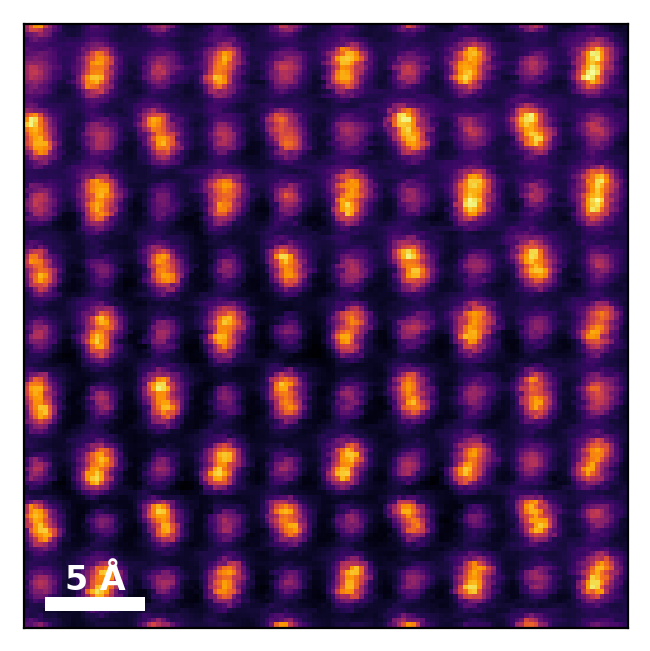

In [2]:
### Load 4D Dataset

dat4d=np.load('/Path/To/4D_Data.npy')
datim=np.load('/Path/To/SimultaneousADF.npy')
md=json.load(open('/Path/To/SimultaneousADF.json','r')) 
### Note this is an old dataset this command doesn't work on latest version of Swift
### I can't use my newest datasets because we're still trying to publish the results
FOV=md['metadata']['hardware_source']['autostem']['fov_nm']

### For my newer datasets on more recent versions of Swift I use 4D dataset .json and 
### the following command
### FOV=md['metadata']['scan_detector']['autostem']['fov_nm']

imcal=FOV/np.amax(dat4d.shape[:2])
f,a=plt.subplots(1,1,dpi=200)
a.imshow(datim,cmap=cm.inferno)
a.add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a.text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=12,ha='center',va='bottom')
plt.setp(a, xticks=[],yticks=[])

[]

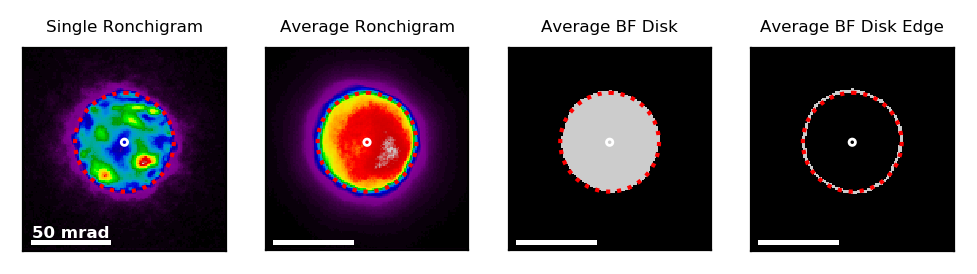

In [3]:
### Calibrate Ronchigram to find calibration and Ronchigram center

ConvergenceAngle=32.

R, RonchiCenterX, RonchiCenterY, Ronchipixcal, BFdiskIm, absct, BFEdgeIm = GetDPC.CalibrateRonchigram(dat4d,conv=ConvergenceAngle,t=0.3)

f,a=plt.subplots(1,4,dpi=200)
a[0].imshow(dat4d[0,0],cmap=cm.nipy_spectral)
a[0].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=ConvergenceAngle*Ronchipixcal,
                    ec='r',fc='None',lw=1.5,ls=':'))
a[0].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=2,ec='w',fc='None',lw=1.))
a[0].set_title('Single Ronchigram',fontsize=6)
a[0].add_patch(Rectangle((4,dat4d.shape[2]-7),50/Ronchipixcal,3,fc='w',ec='None'))
a[0].text(4+25/Ronchipixcal,dat4d.shape[2]-7,'50 mrad',fontweight='bold',color='w',fontsize=6,ha='center',va='bottom')
a[1].imshow(np.average(dat4d,axis=(0,1)),cmap=cm.nipy_spectral)
a[1].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=ConvergenceAngle*Ronchipixcal,
                    ec='r',fc='None',lw=1.5,ls=':'))
a[1].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=2,ec='w',fc='None',lw=1.))
a[1].set_title('Average Ronchigram',fontsize=6)
a[1].add_patch(Rectangle((4,dat4d.shape[2]-7),50/Ronchipixcal,3,fc='w',ec='None'))
a[2].imshow(BFdiskIm,cmap=cm.nipy_spectral)
a[2].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=ConvergenceAngle*Ronchipixcal,
                    ec='r',fc='None',lw=1.5,ls=':'))
a[2].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=2,ec='w',fc='None',lw=1.))
a[2].set_title('Average BF Disk',fontsize=6)
a[2].add_patch(Rectangle((4,dat4d.shape[2]-7),50/Ronchipixcal,3,fc='w',ec='None'))
a[3].imshow(BFEdgeIm,cmap=cm.nipy_spectral)
a[3].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=ConvergenceAngle*Ronchipixcal,
                    ec='r',fc='None',lw=1.5,ls=':'))
a[3].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=2,ec='w',fc='None',lw=1.))
a[3].set_title('Average BF Disk Edge',fontsize=6)
a[3].add_patch(Rectangle((4,dat4d.shape[2]-7),50/Ronchipixcal,3,fc='w',ec='None'))
plt.setp(a, xticks=[],yticks=[])

[]

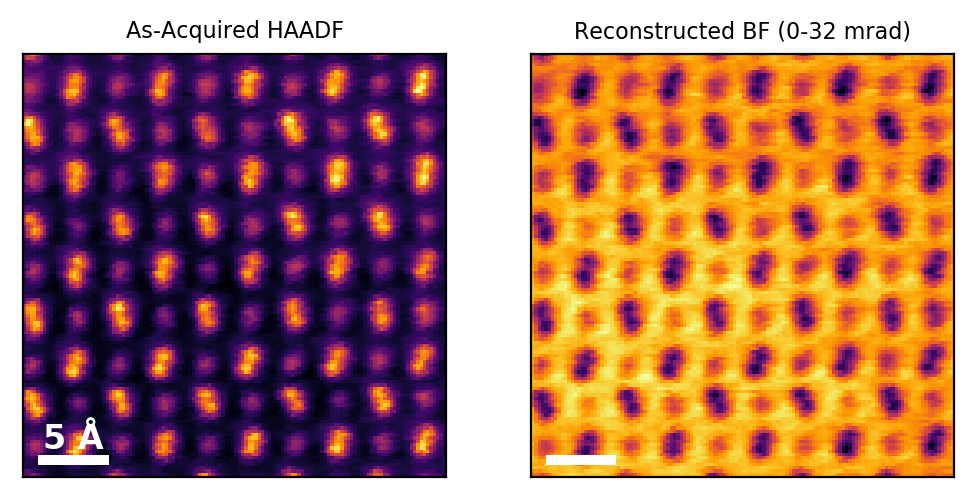

In [4]:
### Use 4D Dataset to reconstruct images from arbitrary detector

BF=GetDPC.GetDetectorImage(dat4d,RonchiCenterX,RonchiCenterY,Ronchipixcal,0.,ConvergenceAngle)
f,a=plt.subplots(1,2,dpi=200)
a[0].imshow(datim,cmap=cm.inferno)
a[0].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[0].text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=12,ha='center',va='bottom')
a[0].set_title('As-Acquired HAADF',fontsize=8)
a[1].imshow(BF,cmap=cm.inferno)
a[1].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('Reconstructed BF (0-32 mrad)',fontsize=8)
plt.setp(a, xticks=[],yticks=[])

[]

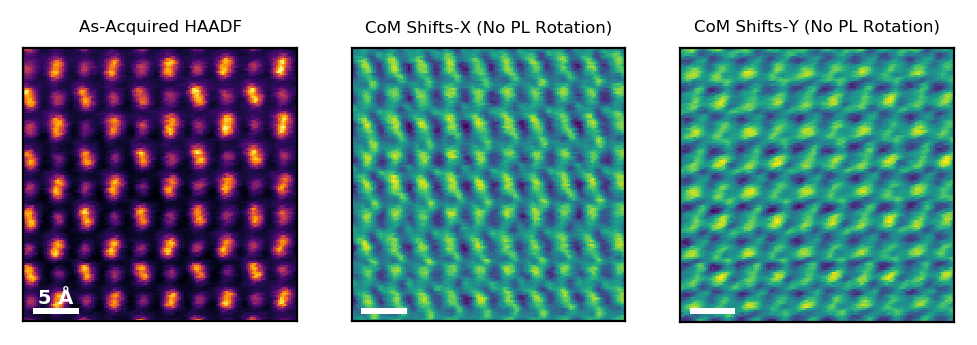

In [5]:
### Calculate Center of Mass Shifts (No Rotation)

CoMX,CoMY=GetDPC.GetiCoM(dat4d,RonchiCenterX,RonchiCenterY,Ronchipixcal)
f,a=plt.subplots(1,3,dpi=200)
a[0].imshow(datim,cmap=cm.inferno)
a[0].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[0].text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=7,ha='center',va='bottom')
a[0].set_title('As-Acquired HAADF',fontsize=6)
a[1].imshow(CoMX)
a[1].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('CoM Shifts-X (No PL Rotation)',fontsize=6)
a[2].imshow(CoMY)
a[2].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[2].set_title('CoM Shifts-Y (No PL Rotation)',fontsize=6)
plt.setp(a, xticks=[],yticks=[])

Pass 1: Angle=18.0
Pass 2: Angle=25.2
Pass 3: Angle=24.5
Pass 4: Angle=24.4


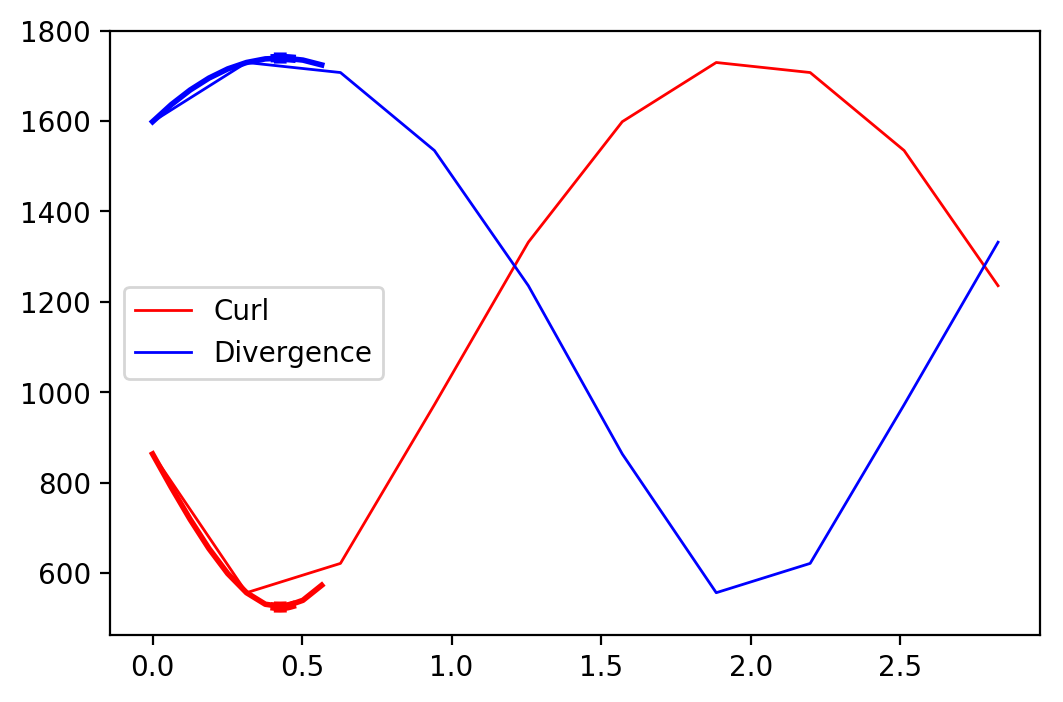

In [6]:
### Calculate PL Rotation

RotationCalcs=GetDPC.GetPLRotation(CoMX,CoMY,order=4,outputall=True)

f,a=plt.subplots(dpi=200)
for i in range(len(RotationCalcs)):
    print('Pass '+str(i+1)+': Angle='+str(round(RotationCalcs[i][0]*180./np.pi,1)))
    a.plot(RotationCalcs[i][1],RotationCalcs[i][2],lw=i+1,color='r',label='Curl')
    a.plot(RotationCalcs[i][1],RotationCalcs[i][3],lw=i+1,color='b',label='Divergence')
    if i==0: a.legend()
PLRotation=RotationCalcs[-1][0]

[]

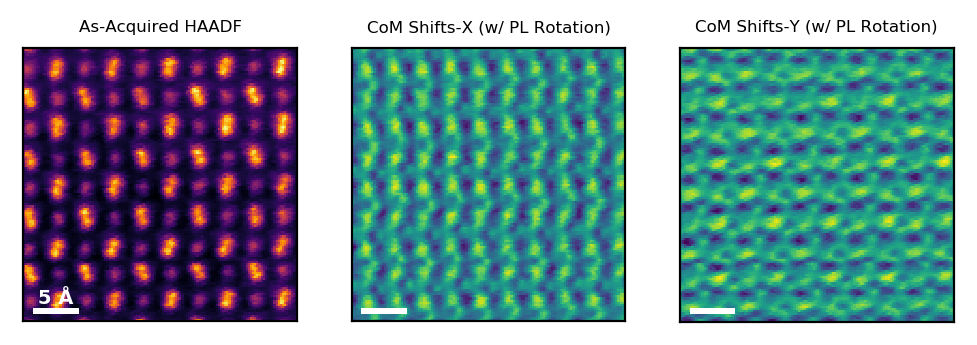

In [7]:
### Calculate Center of Mass Shifts (With Calculated Rotation)

rCoMX,rCoMY=CoMX * np.cos(PLRotation) + CoMY * np.sin(PLRotation), -CoMX * np.sin(PLRotation) + CoMY * np.cos(PLRotation)
f,a=plt.subplots(1,3,dpi=200)
a[0].imshow(datim,cmap=cm.inferno)
a[0].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[0].text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=7,ha='center',va='bottom')
a[0].set_title('As-Acquired HAADF',fontsize=6)
a[1].imshow(rCoMX)
a[1].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('CoM Shifts-X (w/ PL Rotation)',fontsize=6)
a[2].imshow(rCoMY)
a[2].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[2].set_title('CoM Shifts-Y (w/ PL Rotation)',fontsize=6)
plt.setp(a, xticks=[],yticks=[])

[]

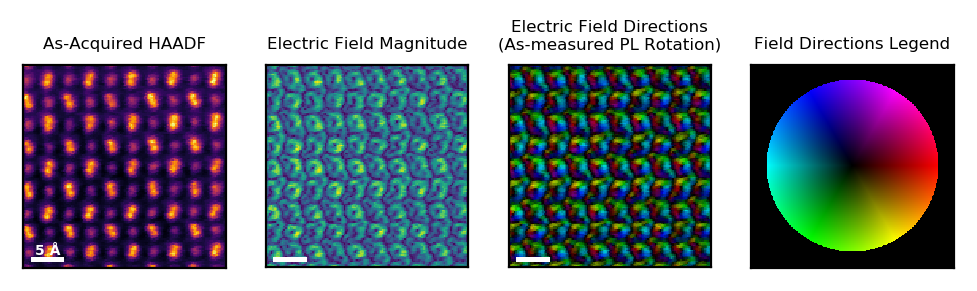

In [8]:
### Calculate Electric Field Magnitude and Direction from Rotated CoM Shifts

EIm,EDirIm,EDirLeg=GetDPC.GetElectricFields(rCoMX,rCoMY)
f,a=plt.subplots(1,4,dpi=200)
a[0].imshow(datim,cmap=cm.inferno)
a[0].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[0].text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=5,ha='center',va='bottom')
a[0].set_title('As-Acquired HAADF',fontsize=6)
a[1].imshow(EIm)
a[1].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('Electric Field Magnitude',fontsize=6)
a[2].imshow(EDirIm)
a[2].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[2].set_title('Electric Field Directions\n(As-measured PL Rotation)',fontsize=6)
a[3].imshow(EDirLeg)
a[3].set_title('Field Directions Legend',fontsize=6)
plt.setp(a, xticks=[],yticks=[])

[]

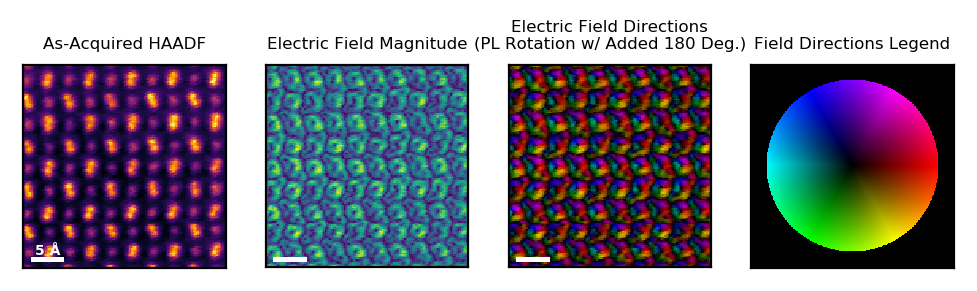

In [10]:
### Calculate Electric Field Magnitude and Direction from Rotated CoM Shifts

EIm,EDirIm,EDirLeg=GetDPC.GetElectricFields(rCoMX,rCoMY,rotation=np.pi)

### NOTE: Without 180 Degree Rotation, E-Field points towards the Nuclei (i.e. goes from negative to positive).
### Since this is not physical, we know the 180 degree rotation is required for this dataset

f,a=plt.subplots(1,4,dpi=200)
a[0].imshow(datim,cmap=cm.inferno)
a[0].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[0].text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=5,ha='center',va='bottom')
a[0].set_title('As-Acquired HAADF',fontsize=6)
a[1].imshow(EIm)
a[1].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('Electric Field Magnitude',fontsize=6)
a[2].imshow(EDirIm)
a[2].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[2].set_title('Electric Field Directions\n(PL Rotation w/ Added 180 Deg.)',fontsize=6)
a[3].imshow(EDirLeg)
a[3].set_title('Field Directions Legend',fontsize=6)
plt.setp(a, xticks=[],yticks=[])

[]

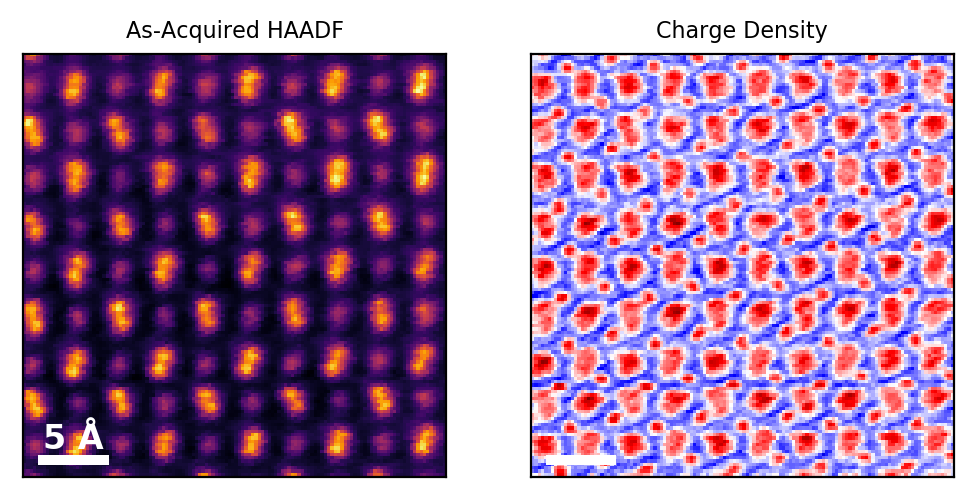

In [12]:
### Calculate Charge Density from Divergence of CoM Shifts

RhoIm = GetDPC.GetChargeDensity(rCoMX, rCoMY, rotation=np.pi)

f,a=plt.subplots(1,2,dpi=200)
a[0].imshow(datim,cmap=cm.inferno)
a[0].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[0].text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=12,ha='center',va='bottom')
a[0].set_title('As-Acquired HAADF',fontsize=8)
a[1].imshow(RhoIm,cmap=cm.seismic,vmin=-np.amax(np.abs(RhoIm)),vmax=np.amax(np.abs(RhoIm)))
a[1].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('Charge Density',fontsize=8)
plt.setp(a, xticks=[],yticks=[])

[]

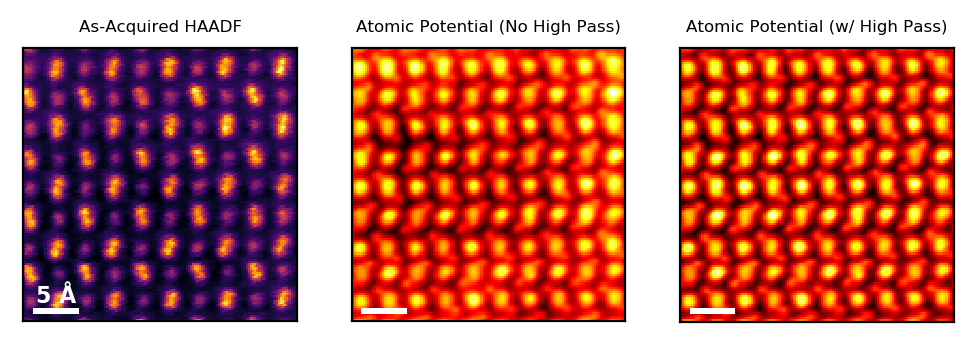

In [14]:
### Calculate Potential from Inverse Gradient of CoM Shifts

VIm=GetDPC.GetPotential(rCoMX,rCoMY,rotation=np.pi)

### Add High Pass Filtering to remove Edge Effects

VImhp=GetDPC.GetPotential(rCoMX,rCoMY,rotation=np.pi,hpass=0.005)

f,a=plt.subplots(1,3,dpi=200)
a[0].imshow(datim,cmap=cm.inferno)
a[0].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[0].text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=8,ha='center',va='bottom')
a[0].set_title('As-Acquired HAADF',fontsize=6)
a[1].imshow(VIm,cmap=cm.hot)
a[1].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('Atomic Potential (No High Pass)',fontsize=6)
a[2].imshow(VImhp,cmap=cm.hot)
a[2].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[2].set_title('Atomic Potential (w/ High Pass)',fontsize=6)
plt.setp(a, xticks=[],yticks=[])